### Problem Description

We have reviews of fine foods from amazon.so we want to make a model that predict the new review is have good description or not(positive or negative).
- First problem is how to clean the data from stopwards and transform the every word to the origin form (Solve by lemmatization).
- Second is how to train model from this data(By using sklearn). 
- Third we need to certain that this model works efficiency (By enter new data).
- Fourth is how to save this model to use it in another reviews (By pickle)
- Finally is to deploy this ml model (By streamlit) 

The link of the data (Amazon Fine Food Reviews)
https://www.kaggle.com/snap/amazon-fine-food-reviews?select=Reviews.csv

# Noticeable
- After running this code put the file of food.py in the same directory of this code to run food.py later in cmd by sreamlit


### Import Packages

In [359]:
# Add environment Packages paths to conda
import os, sys
# env_name = "food_review"
# sys.path.append(f"C:\\Environments\\{env_name}\\lib\\site-packages\\")

import pandas as pd
import numpy as np

# Text preprocessing packages
import nltk # Text libarary
# nltk.download('stopwords')
import string # Removing special characters {#, @, ...}
import re # Regex Package
from nltk.corpus import stopwords # Stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer # Stemmer & Lemmatizer
from gensim.utils import simple_preprocess  # Text ==> List of Tokens

# Text Embedding
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Saving Model
import pickle

# Visualization Packages
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)
%matplotlib inline

### Read Dataset

In [360]:
%%time
df = pd.read_csv('Reviews.csv')

Wall time: 3.95 s


In [361]:
f"{df.shape[0]:,} Review"

'568,454 Review'

In [362]:
cols = ['Text', 'Score']
df_text = df[cols].copy()
df_text.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


### Drop Duplicates
Save the Cleaned data-frame also with the variable `df_text`

In [363]:
df_text = df_text.drop_duplicates().reset_index(drop = True)

In [364]:
df_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393675 entries, 0 to 393674
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    393675 non-null  object
 1   Score   393675 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.0+ MB


### Target Variable Pre-Processing
`target` will be 
 - 0 if score < 3 
 - 1 otherwise

In [365]:
df_text['target'] = df_text['Score'].apply(lambda x : 0 if x < 3 else 1)
df_text.target.value_counts()

1    336591
0     57084
Name: target, dtype: int64

#### Plot Countplot for target Variable

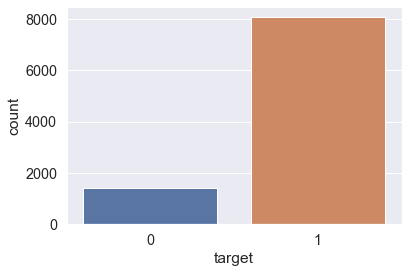

In [366]:
ax = sns.countplot(x="target", data=df_text[:9500])

Notice how such variance is huge ...   
Then we need to down-sample such data ... by which both the positive and negative classes are balanced.

### Balance Data Target

In [367]:
# Sample from positive reviews Same number of negative reviews
NEG_N = df_text.target.value_counts()[0]
df_pos = df_text[df_text['target'] == 1]['Text'].sample(NEG_N, replace=False)
df_text_balanced = pd.concat([df_text.iloc[df_pos.index], df_text[df_text.target == 0]])

(0.0, 1500.0)

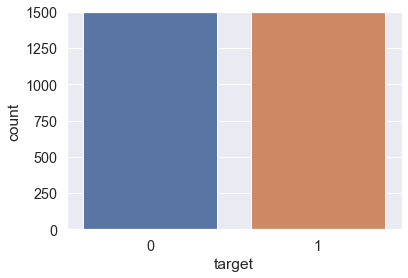

In [368]:
ax = sns.countplot(x="target", data=df_text_balanced)
plt.ylim(0,1500)

### Text Pre-Processing

In [369]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
lemmatizer= WordNetLemmatizer()

In [370]:
df_text_balanced['Text']= df_text_balanced['Text'].apply(lambda x:x.lower())
df_text_balanced['Text'] = df_text_balanced['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df_text_balanced['Text'] = df_text_balanced['Text']. apply(lambda x: [lemmatizer.lemmatize(y,"v") for y in x.split()])
df_text_balanced['Text'] = df_text_balanced['Text'].apply(lambda x: ' '.join([word for word in x ]))
df_text_balanced.sample(10)

,Text,Score,target
248998,receive k cup part introductory sampler i'm ge...,1,0
73942,bad tasting. smell bad bottle taste bad popcor...,1,0
302625,try 6 month old golden retriever puppy start s...,1,0
148295,favorite snack years. purchase bulk easy cost ...,5,1
160069,love little bars. creamy peanut butter delicio...,2,0
15784,"like lighter coffee blend, one good choice. br...",4,1
331242,"dark rich coffee lips, sip slowly................",5,1
240989,"pistachio consumer, know 1 bad nut kill flavor...",1,0
117694,"like manioc/tapioca flour/starch, chebe best! ...",2,0
87751,40 son 5 months ago. start trouble milk supply...,5,1


### Split Test & Training Data

In [371]:
X = df_text_balanced.Text
y = df_text_balanced.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Text Embedding
 - Use `TfidfVectorizer`
 - `fit` on the training data only
 - `transform` on training and test 

In [372]:
## TFIDF embedding for the Description
vectorizer = TfidfVectorizer()
# fit on training (such vectorizer will be saved for deployment)
vectorizer_tfidf = vectorizer.fit(X_train)
# transform on training data
X_train = vectorizer_tfidf.fit_transform(X_train)
# transform on testing data
X_test = vectorizer_tfidf.transform(X_test)

In [373]:
# See the dimensions of your data embeddings before entering to the model
X_train.shape, X_test.shape

((79917, 53425), (34251, 53425))

### Modelling

In [374]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

##### Sklearn framework steps
 - init
 - fit
 - predict

In [375]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
# Fit your Model on the Training Dataset
 
# Predict on Test data
preds = clf.predict(X_test)
# Calculate Model Accuracy
acc = accuracy_score(preds, y_test)
print(f"Model Accuracy = {round(acc*100,2)}%")

Model Accuracy = 84.09%


In [418]:
def stopwords(text):
    stopwords=" ".join([ x for x in text.split() if x not in stop_words])
    return stopwords

In [419]:
def lemmetizer(text):
    lemmatizer = WordNetLemmatizer()
    word_list = nltk.word_tokenize(text)
    lemmatized = ' '.join([lemmatizer.lemmatize(w,'v') for w in word_list])
    return lemmatized

### Raw Instance Prediction

In [420]:
def raw_test(review, model, vectorizer):
    review_c = stopwords(lemmetizer(review))
    # Embed review using tf-idf vectorizer
    embedding = vectorizer.transform([review_c])
    # Predict using your model
    prediction = model.predict(embedding)
    # Return the Sentiment Prediction
    return "Positive" if prediction == 1 else "Negative"

In [421]:
review_1 = "That's a good Dish, Good Job"
review_2 = "That's the worst Dish ever tasted"

In [422]:
raw_test(review_1, clf, vectorizer_tfidf)

'Positive'

In [423]:
raw_test(review_2, clf, vectorizer_tfidf)

'Negative'

### Saving Models for Deployment

In [424]:
import pickle

In [425]:
model_name = 'rf_model.pk'
vectorizer_name = 'tfidf_vectorizer.pk'
model_path = os.path.join('/', model_name)
vect_path = os.path.join('/', vectorizer_name)

pickle.dump(clf, open(model_name, 'wb'))
pickle.dump(vectorizer_tfidf, open(vectorizer_name, 'wb'))

### Load model Again and test them

In [426]:
loaded_model = pickle.load(open(model_name, 'rb'))
loaded_vect = pickle.load(open(vectorizer_name, 'rb'))

In [427]:
raw_test(review_1, loaded_model, loaded_vect)

'Positive'

In [428]:
raw_test(review_2, loaded_model, loaded_vect)

'Negative'

In [417]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, preds)

array([[14796,  2277],
       [ 3172, 14006]], dtype=int64)

# Great Job !
### Now Deploy your ML model using Streamlit Framework